In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import colorsys
import time

In [2]:
class KMeans:
    def __init__(self, k, X, dims=2, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.X = X  # X is the set of all datapoints
        self.k = k  # k is the number of centers
        self.n = X.shape[0]  # n is the number of points in the dataset
        self.dims = dims  # Dimension of the dataset
        self.centroids = X[np.random.choice(self.n, self.k, replace=False)]  # k centroids randomly chosen from X
        self.prev_centroids = np.copy(self.centroids)  # Stores the previous centroids to determine when the centroids have converged
        self.y_pred = np.zeros(self.n) - 1  # Make an array of size n and fill it with -1

    # Assigns centroid number to all the points
    def assign(self):
        # Compute distances between all points and all centroids at once
        # X.shape -> (n, dims), centroids.shape -> (k, dims)
        # This will produce a distance matrix of shape (n, k)
        distances = np.linalg.norm(self.X[:, np.newaxis] - self.centroids, axis=2)

        # Find the index of the minimum distance (closest centroid) for each point
        self.y_pred = np.argmin(distances, axis=1)

        return self.y_pred

    # Updates the location of the centroids
    def update(self):
        self.prev_centroids = np.copy(self.centroids)
        for i in range(self.k):
            cluster_pts = self.X[self.y_pred == i]  # Determines the points that belong to the current cluster
            if len(cluster_pts) > 0:
                self.centroids[i] = np.mean(cluster_pts,axis=0)# Updates the location of the centroid to the center of mass of the cluster
            else:
                self.centroids[i] = np.random.uniform(-10, 10, self.X.shape[
                    1], )  # Picks a random position if there are no points in the cluster

        return self.centroids

    # Runs the K-Means algorithm
    def run(self, verbose=False):
        start = time.time_ns()
        y_hist = [np.copy(self.y_pred), ]  # Keeps track of the label for each point
        centroid_hist = [np.copy(self.centroids), ]  # Keeps track of the centroid locations
        y_hist.append(np.copy(self.assign()))
        centroid_hist.append(np.copy(self.update()))

        i = 0
        while not np.allclose(self.prev_centroids, self.centroids): 
            y_hist.append(np.copy(self.assign()))
            centroid_hist.append(np.copy(self.update()))
            if verbose:
                print(f"Iteration {i}")
            i += 1

        print("K-Means Converged.")
        end = time.time_ns()
        print((1e-6 * (end - start)) // 1, 'milliseconds to converge.')
        return centroid_hist, y_hist

Do you want default params? Y/N :  y


Seed : 99
K-Means Converged.
1.0 milliseconds to converge.
6 iterations to converge.
3 clusters


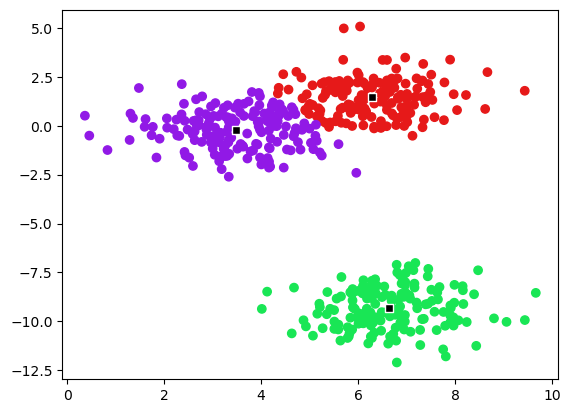

[array([[ 2.40857678,  1.12590012],
       [ 7.35374272, -9.87459571],
       [ 3.23556508, -1.10346047]]), array([[ 4.76697521,  1.50705123],
       [ 6.64512267, -9.33771606],
       [ 4.88238035, -0.14767904]]), array([[ 5.57438547,  1.65602353],
       [ 6.64512267, -9.33771606],
       [ 4.17598058, -0.35376673]]), array([[ 6.22972605,  1.47962142],
       [ 6.64512267, -9.33771606],
       [ 3.49004324, -0.26738432]]), array([[ 6.29490198,  1.45443301],
       [ 6.64512267, -9.33771606],
       [ 3.47727388, -0.21379378]]), array([[ 6.29490198,  1.45443301],
       [ 6.64512267, -9.33771606],
       [ 3.47727388, -0.21379378]])]


In [9]:
WHITE = (255, 255, 255)
GREY = (195, 195, 195)
BLACK = (0, 0, 0)


# Color function to generate distinct colors based on a seed/number
# I stole this code. Don't know why or how it works. Just needed random colors
def colors(num):
    if num == -1:
        return GREY
    hue = (num * 137.508) % 360  # Use golden angle approximation and keep the hue within [0, 360)
    saturation = 0.8
    lightness = 0.5

    r, g, b = colorsys.hls_to_rgb(hue / 360, lightness, saturation)

    return np.array([r,g,b])

# Returns a gaussian mixture with desired number of clusters
def get_random_data(num_points, centers, seed=None):
    if seed is None:
        seed = np.random.randint(1, 1000)
    print(f"Seed : {seed}")
    X, Y = make_blobs(n_samples=num_points, n_features=2, centers=centers, cluster_std=1.0, random_state=seed)
    # Returns both the datapoints and the actual cluster numbers, although it is not used
    return X, Y, seed


# Displays the datapoints as well as the centroids (if any)
def show_data(X, Y_pred, centroids):
    plt.scatter(X[:,0],X[:,1],color = [colors(label) for label in Y_pred])
    plt.scatter(centroids[:,0], centroids[:,1], color = 'black', marker = 's', edgecolors = 'white', linewidths = 1)
    plt.show()


# Setup function for KMeans class
def setup_k_means(X, centers):
    cluster = KMeans(centers, X, dims=2)
    centroids_hist, y_pred_hist = cluster.run()
    y_pred_hist = np.asarray(y_pred_hist, dtype='int32')
    return centroids_hist, y_pred_hist


def distortion(X, y_pred, centroid):
    centroid = np.asarray(centroid)
    distortion = 0
    for i in range(X.shape[0]):
        # print(i, X[i], y_pred[i], centroid[y_pred[i]], np.linalg.norm(X[i] - centroid[y_pred[i]]))
        distortion += np.linalg.norm(X[i] - centroid[y_pred[i]])
    return distortion / X.shape[0]


def elbow_plot(X, k_low=2, k_high=2, plot=False):
    distortions = []
    for i in range(k_low, k_high + 1):
        centroids_hist, y_pred_hist = setup_k_means(X, i)
        distortions.append(distortion(X, y_pred_hist[-1], centroids_hist[-1], ))

    if plot:
        plt.plot(list(range(k_low, k_high + 1)), distortions)
        plt.xticks(list(range(k_low, k_high + 1)))
        plt.title('Elbow plot')
        plt.ylabel('Distortion')
        plt.xlabel('k')
        plt.show()

    return distortions


def menu_driven(default_params = None):
    if default_params is None:
        centers = int(input("Enter number of centers for the random data : "))
    
        seed = input("Enter the seed if any. Type None for random seed : ")
        if seed.lower() == "none":
            seed = None
        else:
            seed = int(seed)
    
        num_points = int(input("Enter the number of points : "))
        
        elbow = input("Do you want an elbow plot? Y/N : ")
    else:
        centers, seed, num_points, elbow = default_params

    X, _, seed = get_random_data(num_points, centers, seed)
    if elbow.upper() == 'Y':
        low = int(input("Enter lower limit of centroids : "))
        high = int(input("Enter upper limit of centroids : "))
        elbow_plot(X, low, high, True)
        quit()
    else:
        centroids_hist, y_pred_hist = setup_k_means(X, centers)

    print(f"{len(y_pred_hist)} iterations to converge.")
    print(np.max(y_pred_hist) + 1, "clusters")

    return X, centroids_hist, y_pred_hist

op = input("Do you want default params? Y/N : ")
if op.lower() == 'y':
    def_params = [3,None ,500,'N']
else:
    def_params = None

X, centroids_hist, y_pred_hist = menu_driven(def_params)

show_data(X,np.asarray(y_pred_hist[-1]),np.asarray(centroids_hist[-1]))

print(centroids_hist)